In [1]:
import numpy as np
from genreclassification.utils import get_project_root
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.callbacks import History, EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

import dataframe_image as dfi
pd.set_option("display.max_columns", None)

2023-01-12 12:08:03.992644: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# cnn transfer learning (vgg16); train all layers

* train CNN from here or jump to [testing](#performance-on-test-set) to load a saved model

In [2]:
genres = ["blues", "classical", "country", "disco",	"hiphop", "jazz", "metal", "pop", "reggae", "rock"]

In [3]:
train_path = get_project_root()/"data/images_split/train"
val_path = get_project_root()/"data/images_split/val"
test_path = get_project_root()/"data/images_split/test"

In [4]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(244,244), classes=genres, batch_size=16)

val_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=val_path, target_size=(244,244), classes=genres, batch_size=16)

Found 639 images belonging to 10 classes.
Found 160 images belonging to 10 classes.


In [5]:
vgg16 = tf.keras.applications.vgg16.VGG16()

2023-01-12 12:08:09.702875: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# vgg16.summary()

In [7]:
vgg_model = Sequential()
for layer in vgg16.layers[:-1]:
    vgg_model.add(layer)

In [8]:
for layer in vgg_model.layers:
    layer.trainable = True

In [9]:
vgg_model.add(Dense(units=10, activation="softmax"))

In [10]:
# vgg_model.summary()

In [11]:
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
epochs = 16
history = History()

# restore best model by val_loss
# patience == num epochs so doesn't actually stop early
early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    restore_best_weights=True,
    patience=epochs,
    baseline=None
)

vgg_model.fit(
    x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=val_batches,
    validation_steps=len(val_batches),
    epochs=epochs,
    verbose=2,
    callbacks=[
        history,
        early_stopping
    ]
)

Epoch 1/16
40/40 - 325s - loss: 27.1766 - accuracy: 0.0939 - val_loss: 2.8480 - val_accuracy: 0.1000 - 325s/epoch - 8s/step
Epoch 2/16
40/40 - 278s - loss: 2.5815 - accuracy: 0.0736 - val_loss: 2.4299 - val_accuracy: 0.1000 - 278s/epoch - 7s/step
Epoch 3/16
40/40 - 277s - loss: 2.6984 - accuracy: 0.0814 - val_loss: 2.4837 - val_accuracy: 0.1000 - 277s/epoch - 7s/step
Epoch 4/16
40/40 - 275s - loss: 2.5992 - accuracy: 0.0689 - val_loss: 2.3940 - val_accuracy: 0.1187 - 275s/epoch - 7s/step
Epoch 5/16
40/40 - 274s - loss: 2.4776 - accuracy: 0.0923 - val_loss: 2.3626 - val_accuracy: 0.1063 - 274s/epoch - 7s/step
Epoch 6/16
40/40 - 274s - loss: 2.3719 - accuracy: 0.0986 - val_loss: 2.3034 - val_accuracy: 0.1312 - 274s/epoch - 7s/step
Epoch 7/16
40/40 - 273s - loss: 3.5264 - accuracy: 0.1252 - val_loss: 3.0674 - val_accuracy: 0.1000 - 273s/epoch - 7s/step
Epoch 8/16
40/40 - 274s - loss: 3.8664 - accuracy: 0.0923 - val_loss: 2.6053 - val_accuracy: 0.1000 - 274s/epoch - 7s/step
Epoch 9/16
40/4

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

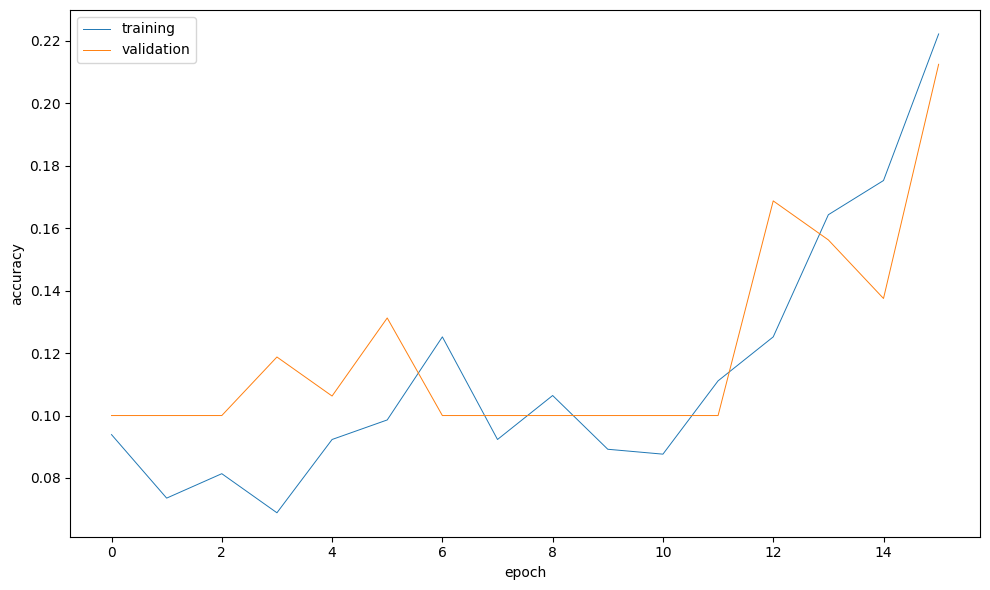

In [32]:
fig = plt.figure(
    figsize=(10,6)
)
ax = fig.add_subplot(111)

ax.plot(history.history["accuracy"], label="training", linewidth=0.7)
ax.plot(history.history["val_accuracy"], label="validation", linewidth=0.7)

ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.legend()

fig.tight_layout()

### save training fig:

In [33]:
fig.savefig(
    get_project_root() / "output/vgg16-train-all-layers/vgg16-train-all-layers_train-val.svg"
)
fig.savefig(
    get_project_root() / "output/vgg16-train-all-layers/vgg16-train-all-layers_train-val.png"
)

### save model:

In [16]:
vgg_model.save(
    get_project_root() / "models/vgg-all-layers/vgg-all-layers"
)

INFO:tensorflow:Assets written to: /Users/djq98242/repos/genre_classification/models/vgg-all-layers/vgg-all-layers/assets


INFO:tensorflow:Assets written to: /Users/djq98242/repos/genre_classification/models/vgg-all-layers/vgg-all-layers/assets


## performance on test set

In [17]:
genres = ["blues", "classical", "country", "disco",	"hiphop", "jazz", "metal", "pop", "reggae", "rock"]

test_path = get_project_root()/"data/images_split/test"

# load test set with shuffle=False
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(244,244), classes=genres, batch_size=16, shuffle=False)

Found 200 images belonging to 10 classes.


### load model:

In [18]:
# vgg_model = load_model(
#     get_project_root() / "models/vgg-all-layers/vgg-all-layers"
# )

In [19]:
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

### prediction:

In [20]:
pred = vgg_model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [21]:
score =(loss, Accuracy) = vgg_model.evaluate(x=test_batches, steps= len(test_batches), verbose=0)
print(f"tf accuracy: {score[1]}")

tf accuracy: 0.23499999940395355


In [22]:
pred_class = np.argmax(pred, axis=1)
# pred_class = pd.Series(pred_class)

In [23]:
cm = confusion_matrix(
    test_batches.classes,
    pred_class
)
cm

array([[ 0,  3,  8,  5,  0,  3,  0,  0,  1,  0],
       [ 0, 13,  3,  0,  0,  4,  0,  0,  0,  0],
       [ 0,  2, 12,  3,  0,  2,  0,  0,  1,  0],
       [ 0,  0,  5, 15,  0,  0,  0,  0,  0,  0],
       [ 0,  3,  7,  9,  0,  0,  0,  0,  1,  0],
       [ 0,  6,  5,  3,  0,  6,  0,  0,  0,  0],
       [ 0,  0,  6, 14,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  3, 17,  0,  0,  0,  0,  0,  0],
       [ 0,  2,  7,  9,  0,  1,  0,  0,  1,  0],
       [ 0,  0,  5, 14,  0,  0,  0,  0,  1,  0]])

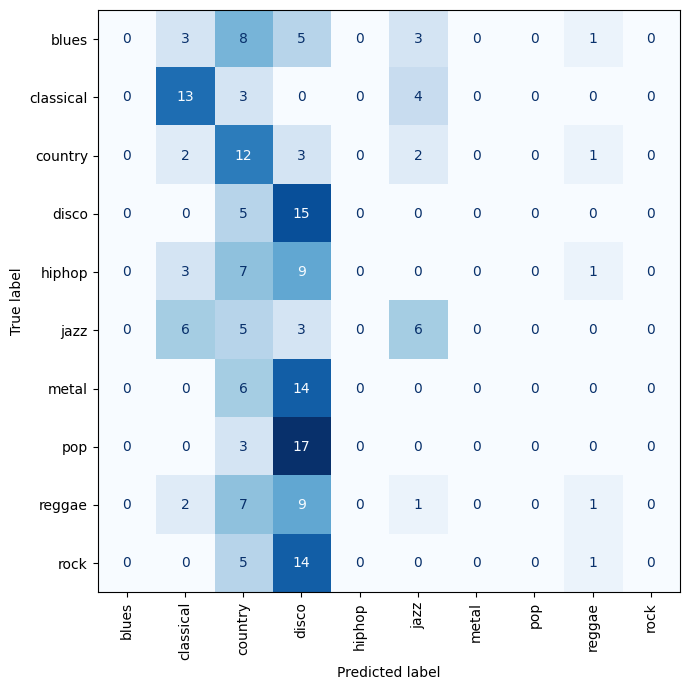

In [24]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ConfusionMatrixDisplay(
    cm,
    display_labels=genres
).plot(
    xticks_rotation=90,
    cmap="Blues",
    colorbar=False,
    ax=ax
)
fig.tight_layout()

In [25]:
fig.savefig(
    get_project_root() / "output/vgg16-train-all-layers/vgg16-train-all-layers_cm.svg"
)
fig.savefig(
    get_project_root() / "output/vgg16-train-all-layers/vgg16-train-all-layers_cm.png"
)

In [26]:
def average_metrics(y_test, y_pred):
    scorers = {
        "accuracy": accuracy_score(y_test, y_pred),
        "f1_micro": f1_score(y_test, y_pred, average="micro"),
        "f1_macro": f1_score(y_test, y_pred, average="macro"),
        "recall_micro": recall_score(y_test, y_pred, average="micro"),
        "recall_macro": recall_score(y_test, y_pred, average="macro"),
        "precision_micro": precision_score(y_test, y_pred, average="micro"),
        "precision_macro": precision_score(y_test, y_pred, average="macro")
    }
    df = pd.DataFrame(index=scorers.keys(), columns=["metric score"])
    for scorer in scorers.keys():
        df.at[scorer, "metric score"] = scorers[scorer]
    df=df.transpose()
    return df

def class_metrics(y_test, y_pred, class_labels):
    df = pd.DataFrame(index=list(class_labels))

    for scorer in [
        ("recall", recall_score),
        ("precision", precision_score),
        ("f1", f1_score)
    ]:
        metric_score = scorer[1](
            y_test,
            y_pred,
            average=None,
            # labels=list(class_labels)
        )
        df[scorer[0]] = metric_score

    df = df.transpose()

    return df

In [27]:
av_metrics = average_metrics(test_batches.classes, pred_class)
av_metrics

/Users/djq98242/Library/Caches/pypoetry/virtualenvs/genreclassification-qGJVucn0-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,accuracy,f1_micro,f1_macro,recall_micro,recall_macro,precision_micro,precision_macro
metric score,0.235,0.235,0.151547,0.235,0.235,0.235,0.138854


In [28]:
dfi.export(
    av_metrics,
    "../output/vgg16-train-all-layers/vgg16-train-all-layers_average_metrics.png"
)

av_metrics_t = av_metrics.transpose()
dfi.export(
    av_metrics_t,
    "../output/vgg16-train-all-layers/vgg16-train-all-layers_average_metrics_t.png"
)

[0112/132434.924300:INFO:headless_shell.cc(223)] 20719 bytes written to file /var/folders/ng/4x8hyf_s39b2rqzs184hl_lr0000gp/T/tmptb2s0jgw/temp.png
[0112/132435.937034:INFO:headless_shell.cc(223)] 28108 bytes written to file /var/folders/ng/4x8hyf_s39b2rqzs184hl_lr0000gp/T/tmp0a03rvhl/temp.png


In [29]:
c_metrics = class_metrics(
    test_batches.classes,
    pred_class,
    genres
)
c_metrics

/Users/djq98242/Library/Caches/pypoetry/virtualenvs/genreclassification-qGJVucn0-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
recall,0.0,0.448276,0.196721,0.168539,0.0,0.375000,0.0,0.0,0.20,0.0
precision,0.0,0.650000,0.600000,0.750000,0.0,0.300000,0.0,0.0,0.05,0.0
f1,0.0,0.530612,0.296296,0.275229,0.0,0.333333,0.0,0.0,0.08,0.0


In [30]:
dfi.export(
    c_metrics,
    "../output/vgg16-train-all-layers/vgg16-train-all-layers_class_metrics.png"
)

c_metrics_t = c_metrics.transpose()
dfi.export(
    c_metrics_t,
    "../output/vgg16-train-all-layers/vgg16-train-all-layers_class_metrics_t.png"
)

[0112/132437.570590:INFO:headless_shell.cc(223)] 31956 bytes written to file /var/folders/ng/4x8hyf_s39b2rqzs184hl_lr0000gp/T/tmp66elojbh/temp.png
[0112/132438.263575:INFO:headless_shell.cc(223)] 39848 bytes written to file /var/folders/ng/4x8hyf_s39b2rqzs184hl_lr0000gp/T/tmpnfqcrboh/temp.png
